In [1]:
!pip install easyocr
!pip install opencv-python
!pip install matplotlib
!pip install pdf2image
!pip install PyMuPDF
!pip install -qqq Pillow==9.0.1 --progress-bar off
!pip install --upgrade pdf2image
!apt-get install poppler-utils

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
!pip uninstall -y Pillow
!pip install -qqq Pillow --progress-bar off

Found existing installation: Pillow 9.0.1
Uninstalling Pillow-9.0.1:
  Successfully uninstalled Pillow-9.0.1


In [1]:
import easyocr
import cv2
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
import numpy as np
from pathlib import Path
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import json
import os

In [2]:
# Initialize the EasyOCR readers for Arabic and English
arabic_reader = easyocr.Reader(['ar'], gpu=True)
english_reader = easyocr.Reader(['en'], gpu=True)


In [3]:
def create_bounding_box(bbox_data):
    xs = []
    ys = []
    for x, y in bbox_data:
        xs.append(x)
        ys.append(y)
    left = int(min(xs))
    top = int(min(ys))
    right = int(max(xs))
    bottom = int(max(ys))
    return [left, top, right, bottom]


In [4]:
def draw_and_extract_boxes(image, results, output_dir="output"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    extracted_data = []

    for i, (bbox, text, prob) in enumerate(results):
        print(f"Text: {text}, Probability: {prob:.4f}")
        left, top, right, bottom = create_bounding_box(bbox)


        cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)

        roi = image[top:bottom, left:right]


        roi_filename = os.path.join(output_dir, f"extracted_text_{i+1}.png")
        cv2.imwrite(roi_filename, roi)


        extracted_data.append({
            "word": text,
            "confidence": prob,
            "bounding_box": {
                "left": left,
                "top": top,
                "right": right,
                "bottom": bottom
            },
            "roi_image_path": roi_filename
        })

    return image, extracted_data

In [5]:
def save_annotated_pages_as_pdf(annotated_images, output_pdf_path):
    pil_images = [Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) for img in annotated_images]
    pil_images[0].save(output_pdf_path, save_all=True, append_images=pil_images[1:])


In [6]:

def ocr_pdf_to_individual_json(pdf_path, language='ar', output_dir="output_pdf_pages", save_pdf=True):


    pages = convert_from_path(pdf_path, dpi=300)     # PDF -> images

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    annotated_images = []
    full_text = ""

    reader = arabic_reader if language == 'ar' else english_reader
    text_output_path = os.path.join(output_dir, "extracted_text.txt")

    with open(text_output_path, "w", encoding="utf-8") as text_file:
         for i, page in enumerate(tqdm(pages, desc=f"Processing {language.upper()} PDF pages")):
            page_number = i+1
            page_image = np.array(page)
            page_image = cv2.cvtColor(page_image, cv2.COLOR_RGB2BGR)

            json_output_path = os.path.join(output_dir, f"page_{ page_number}.json")


            results = reader.readtext(page_image)


            page_image_with_boxes, extracted_data = draw_and_extract_boxes(page_image, results, output_dir)

            annotated_images.append(page_image_with_boxes)

            # Save the OCR results to a JSON file
            with open(json_output_path, "w", encoding="utf-8") as f:
                json_object = json.dumps(extracted_data, indent=4, ensure_ascii=False, default=str)
                f.write(json_object)


            page_text = ""
            for item in extracted_data:
                page_text += item['word'] + "\n"
                full_text += item['word'] + "\n"

            text_file.write(page_text)


            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 24))

            original_image = Image.fromarray(cv2.cvtColor(page_image, cv2.COLOR_BGR2RGB))  # GPR->>RGB


            text_image = Image.new("RGB", original_image.size, (255, 255, 255))
            draw = ImageDraw.Draw(text_image)


            font_size = 60
            font = ImageFont.truetype("/content/DejaVuSansCondensed-Bold.ttf", font_size)


            draw.text((10, 10), page_text, fill="black", font=font)

            ax1.imshow(original_image)
            ax2.imshow(text_image)
            ax1.axis("off")
            ax2.axis("off")
            plt.show()

            print(f"OCR results for page {i+1} saved to {json_output_path}")

    print(f"Extracted text saved to {text_output_path}")


    if annotated_images:
        output_pdf_path = os.path.join(output_dir, "annotated_output.pdf")
        save_annotated_pages_as_pdf(annotated_images, output_pdf_path)
        print(f"Annotated PDF saved to {output_pdf_path}")
    else:
        print("No annotated images to save as PDF.")


Processing EN PDF pages:   0%|          | 0/5 [00:00<?, ?it/s]

Text: Life, Probability: 0.9998
Text: Life is like, Probability: 0.8168
Text: a, Probability: 0.9981
Text: journey filled with ups and, Probability: 0.9701
Text: downs:, Probability: 0.7971
Text: It's, Probability: 0.7720
Text: a, Probability: 0.9949
Text: mix, Probability: 1.0000
Text: of, Probability: 0.9989
Text: joy, Probability: 0.9972
Text: and, Probability: 1.0000
Text: sOrrow,, Probability: 0.6373
Text: success, Probability: 0.9412
Text: and, Probability: 1.0000
Text: failure., Probability: 0.9961
Text: Each, Probability: 0.8310
Text: brings, Probability: 1.0000
Text: new, Probability: 1.0000
Text: experiences, Probability: 0.8107
Text: and, Probability: 1.0000
Text: challenges,, Probability: 0.9491
Text: shaping, Probability: 1.0000
Text: who, Probability: 0.9993
Text: we, Probability: 0.9948
Text: are_, Probability: 0.9996
Text: Sometimes, Probability: 0.9997
Text: it's, Probability: 0.9148
Text: smooth, Probability: 0.9999
Text: sailing,, Probability: 0.8930
Text: other, Pro

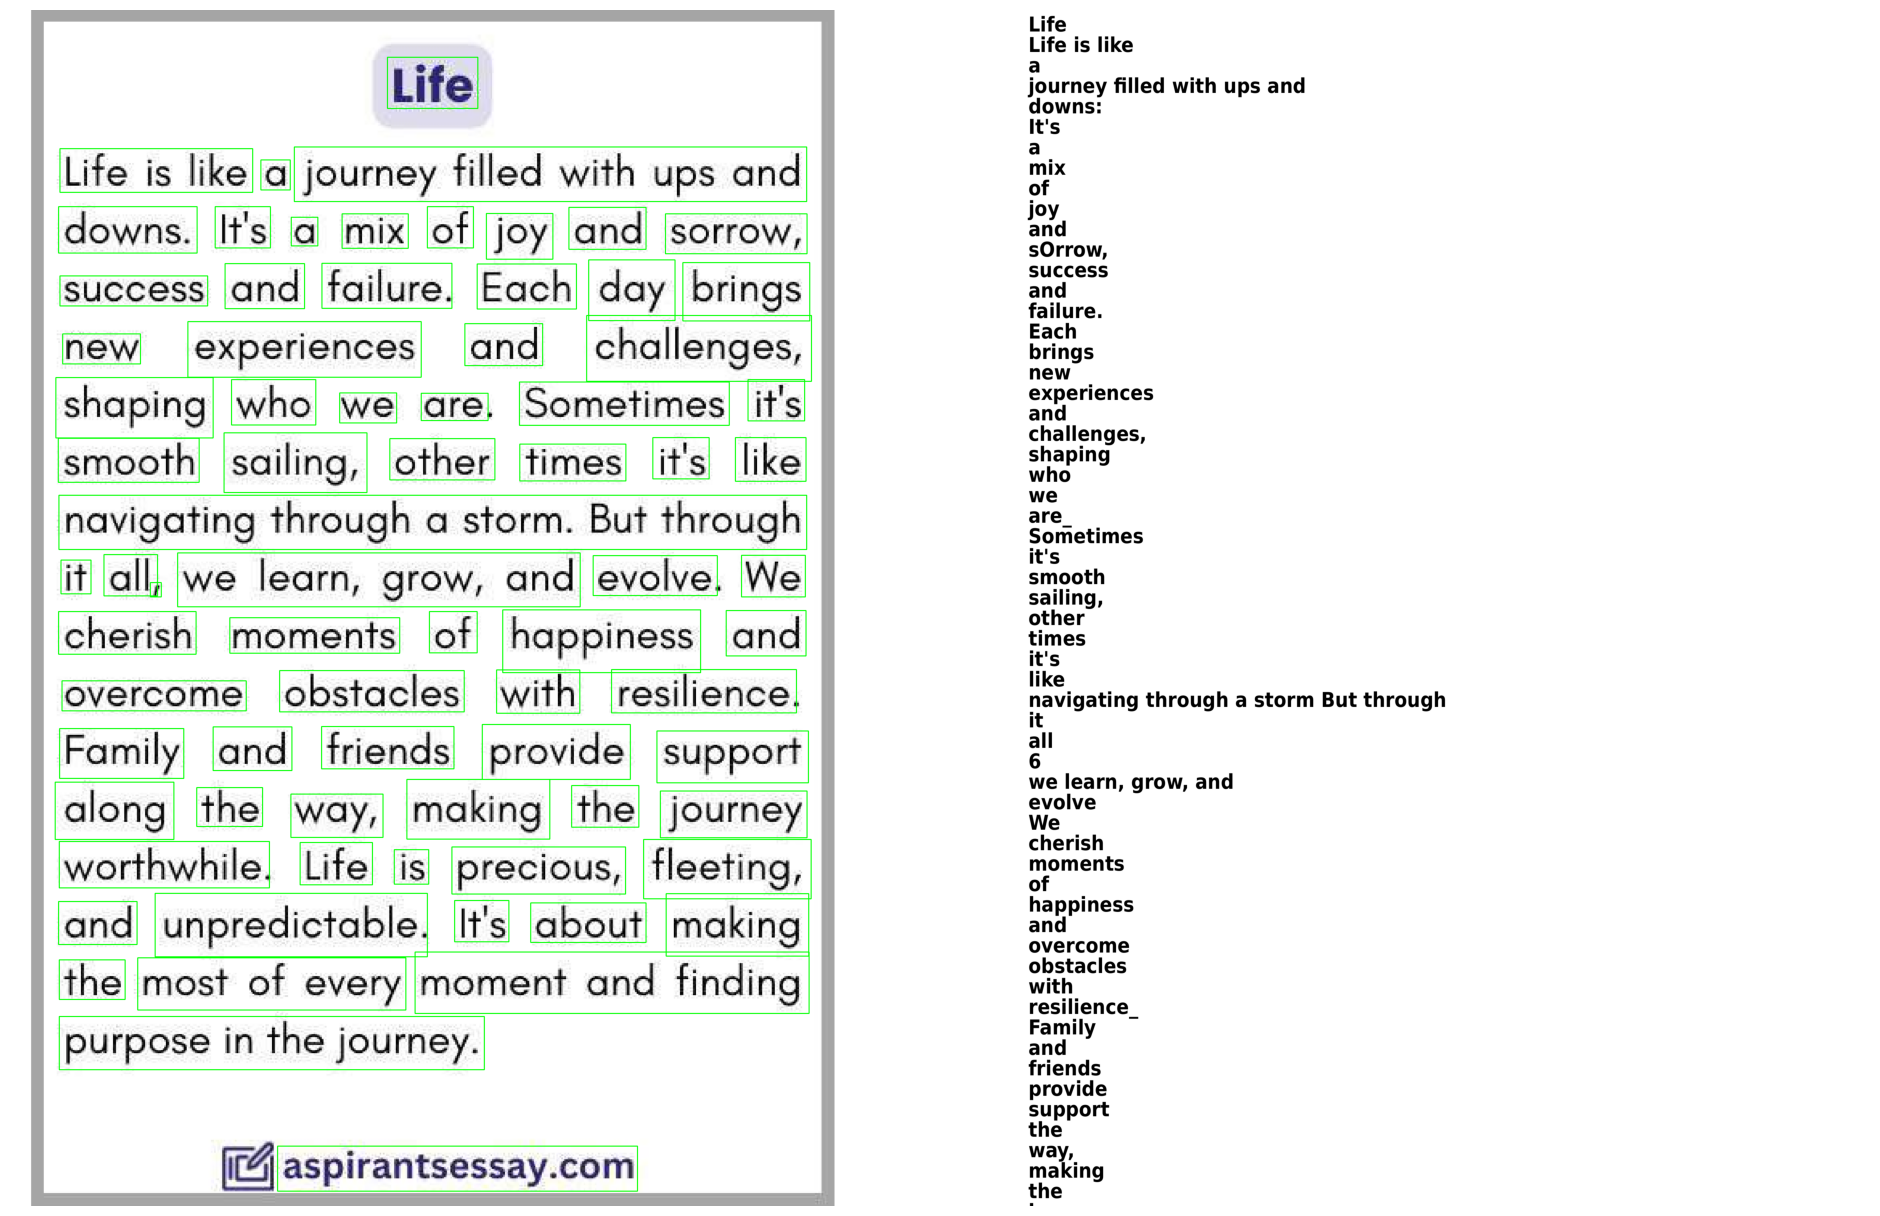

Processing EN PDF pages:  20%|██        | 1/5 [00:05<00:21,  5.41s/it]

OCR results for page 1 saved to output_pdf_english/page_1.json
Text: Hobby, Probability: 0.9999
Text: Hobbies, Probability: 0.9967
Text: are, Probability: 1.0000
Text: like, Probability: 0.9943
Text: little, Probability: 0.9946
Text: pockets, Probability: 1.0000
Text: of, Probability: 0.9938
Text: happiness, Probability: 0.9924
Text: in, Probability: 0.9000
Text: our, Probability: 0.9945
Text: lives., Probability: 0.6033
Text: 0, Probability: 0.1456
Text: Mine, Probability: 1.0000
Text: is, Probability: 0.9905
Text: gardening:, Probability: 0.9496
Text: 1, Probability: 0.2317
Text: find, Probability: 0.9996
Text: solace, Probability: 0.9999
Text: in, Probability: 0.5967
Text: nurturing, Probability: 0.9022
Text: plants and watching them grow. There's, Probability: 0.7416
Text: something magical about seeing, Probability: 0.9982
Text: a, Probability: 0.9998
Text: tiny, Probability: 0.9996
Text: seed transform, Probability: 0.9687
Text: into, Probability: 0.9997
Text: a, Probability: 0.2

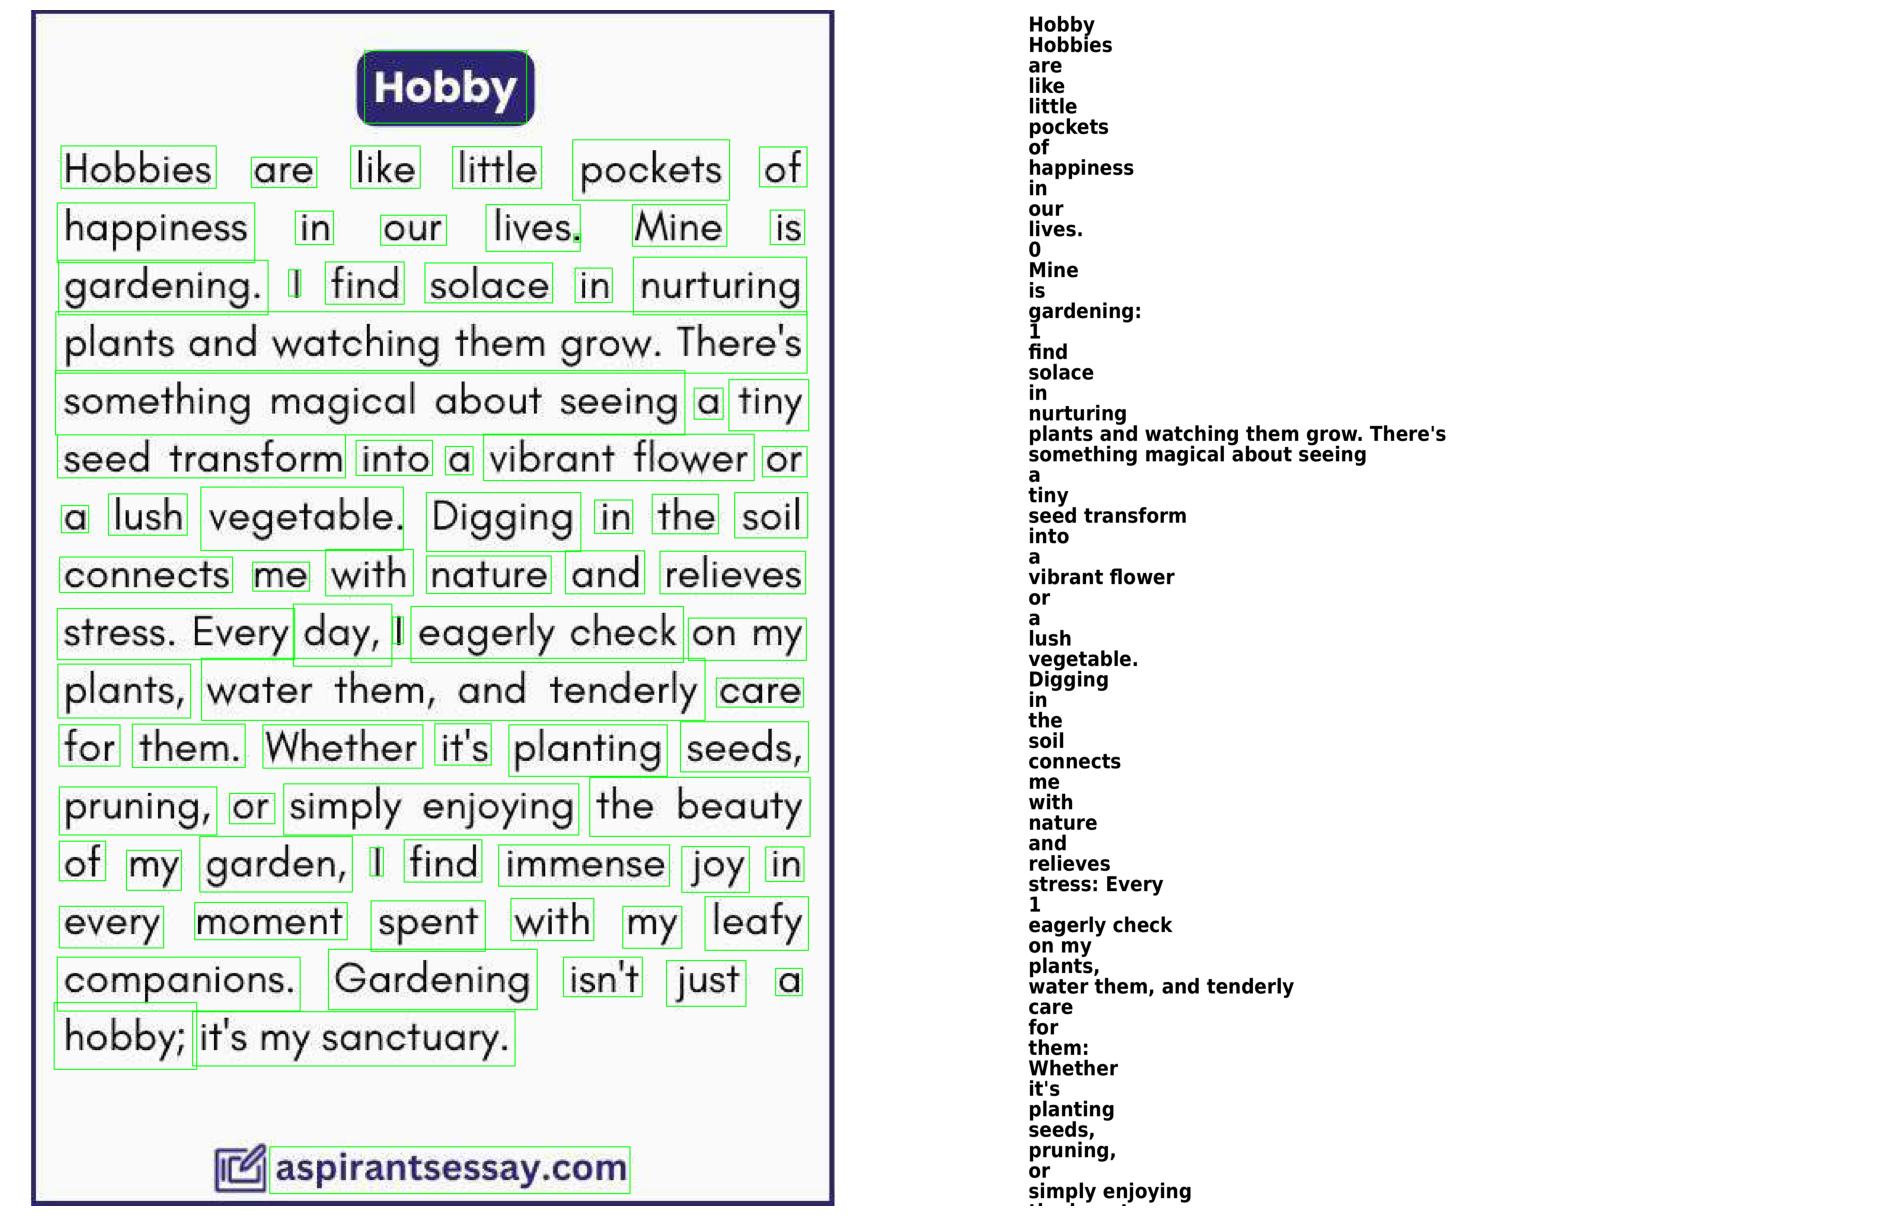

Processing EN PDF pages:  40%|████      | 2/5 [00:10<00:15,  5.00s/it]

OCR results for page 2 saved to output_pdf_english/page_2.json
Text: Hard Work, Probability: 0.9996
Text: Hard, Probability: 1.0000
Text: work, Probability: 0.9996
Text: is, Probability: 0.9946
Text: the, Probability: 1.0000
Text: to, Probability: 0.9997
Text: success_, Probability: 0.9951
Text: E, Probability: 0.0295
Text: It, Probability: 0.9946
Text: requires, Probability: 1.0000
Text: dedication, Probability: 1.0000
Text: and, Probability: 1.0000
Text: consistent, Probability: 0.9998
Text: effort_, Probability: 0.9999
Text: By, Probability: 0.9998
Text: working, Probability: 0.9883
Text: hard,, Probability: 0.5443
Text: we, Probability: 0.9325
Text: can, Probability: 0.9998
Text: achieve, Probability: 0.9990
Text: our, Probability: 0.9985
Text: and, Probability: 1.0000
Text: improve, Probability: 0.9994
Text: our, Probability: 0.9979
Text: abilities_, Probability: 0.9992
Text: Hard, Probability: 1.0000
Text: work, Probability: 0.9998
Text: teaches, Probability: 0.9983
Text: uS, Pro

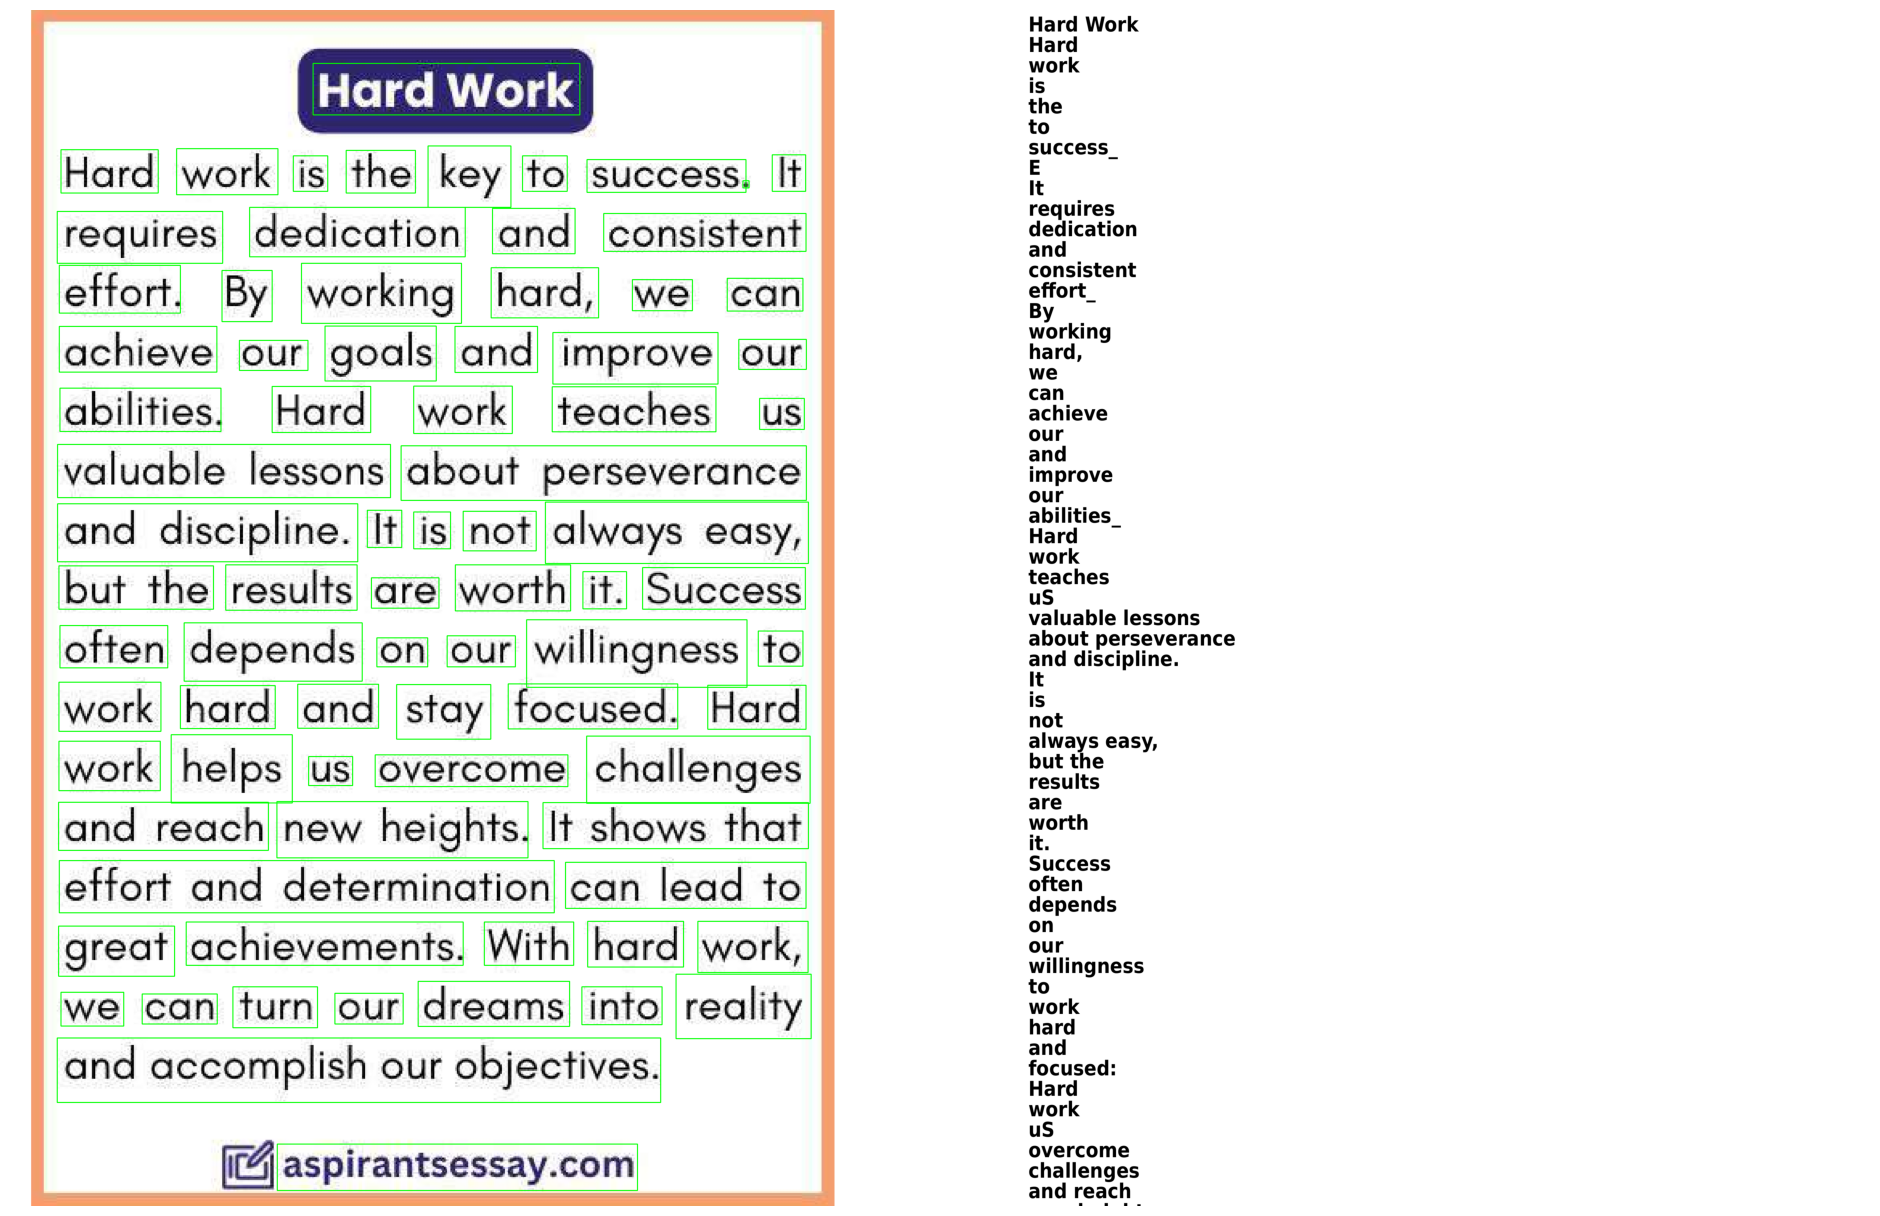

Processing EN PDF pages:  60%|██████    | 3/5 [00:15<00:10,  5.10s/it]

OCR results for page 3 saved to output_pdf_english/page_3.json
Text: Importance ot English, Probability: 0.8337
Text: English, Probability: 1.0000
Text: is, Probability: 0.9825
Text: incredibly important, Probability: 0.9978
Text: in, Probability: 0.9995
Text: our, Probability: 0.9981
Text: world, Probability: 0.9997
Text: Its like a key that unlocks, Probability: 0.8736
Text: many, Probability: 0.9999
Text: doors_, Probability: 0.9977
Text: When you, Probability: 0.9871
Text: English, Probability: 0.9978
Text: well, you, Probability: 0.7619
Text: can talk with, Probability: 0.9989
Text: people from all, Probability: 0.7912
Text: over, Probability: 0.9984
Text: the, Probability: 0.9998
Text: world_, Probability: 0.9970
Text: This, Probability: 0.9999
Text: you learn, Probability: 0.9690
Text: new, Probability: 1.0000
Text: and, Probability: 1.0000
Text: find, Probability: 0.9998
Text: better, Probability: 0.9997
Text: opportunities., Probability: 0.6563
Text: In school,, Probability: 0

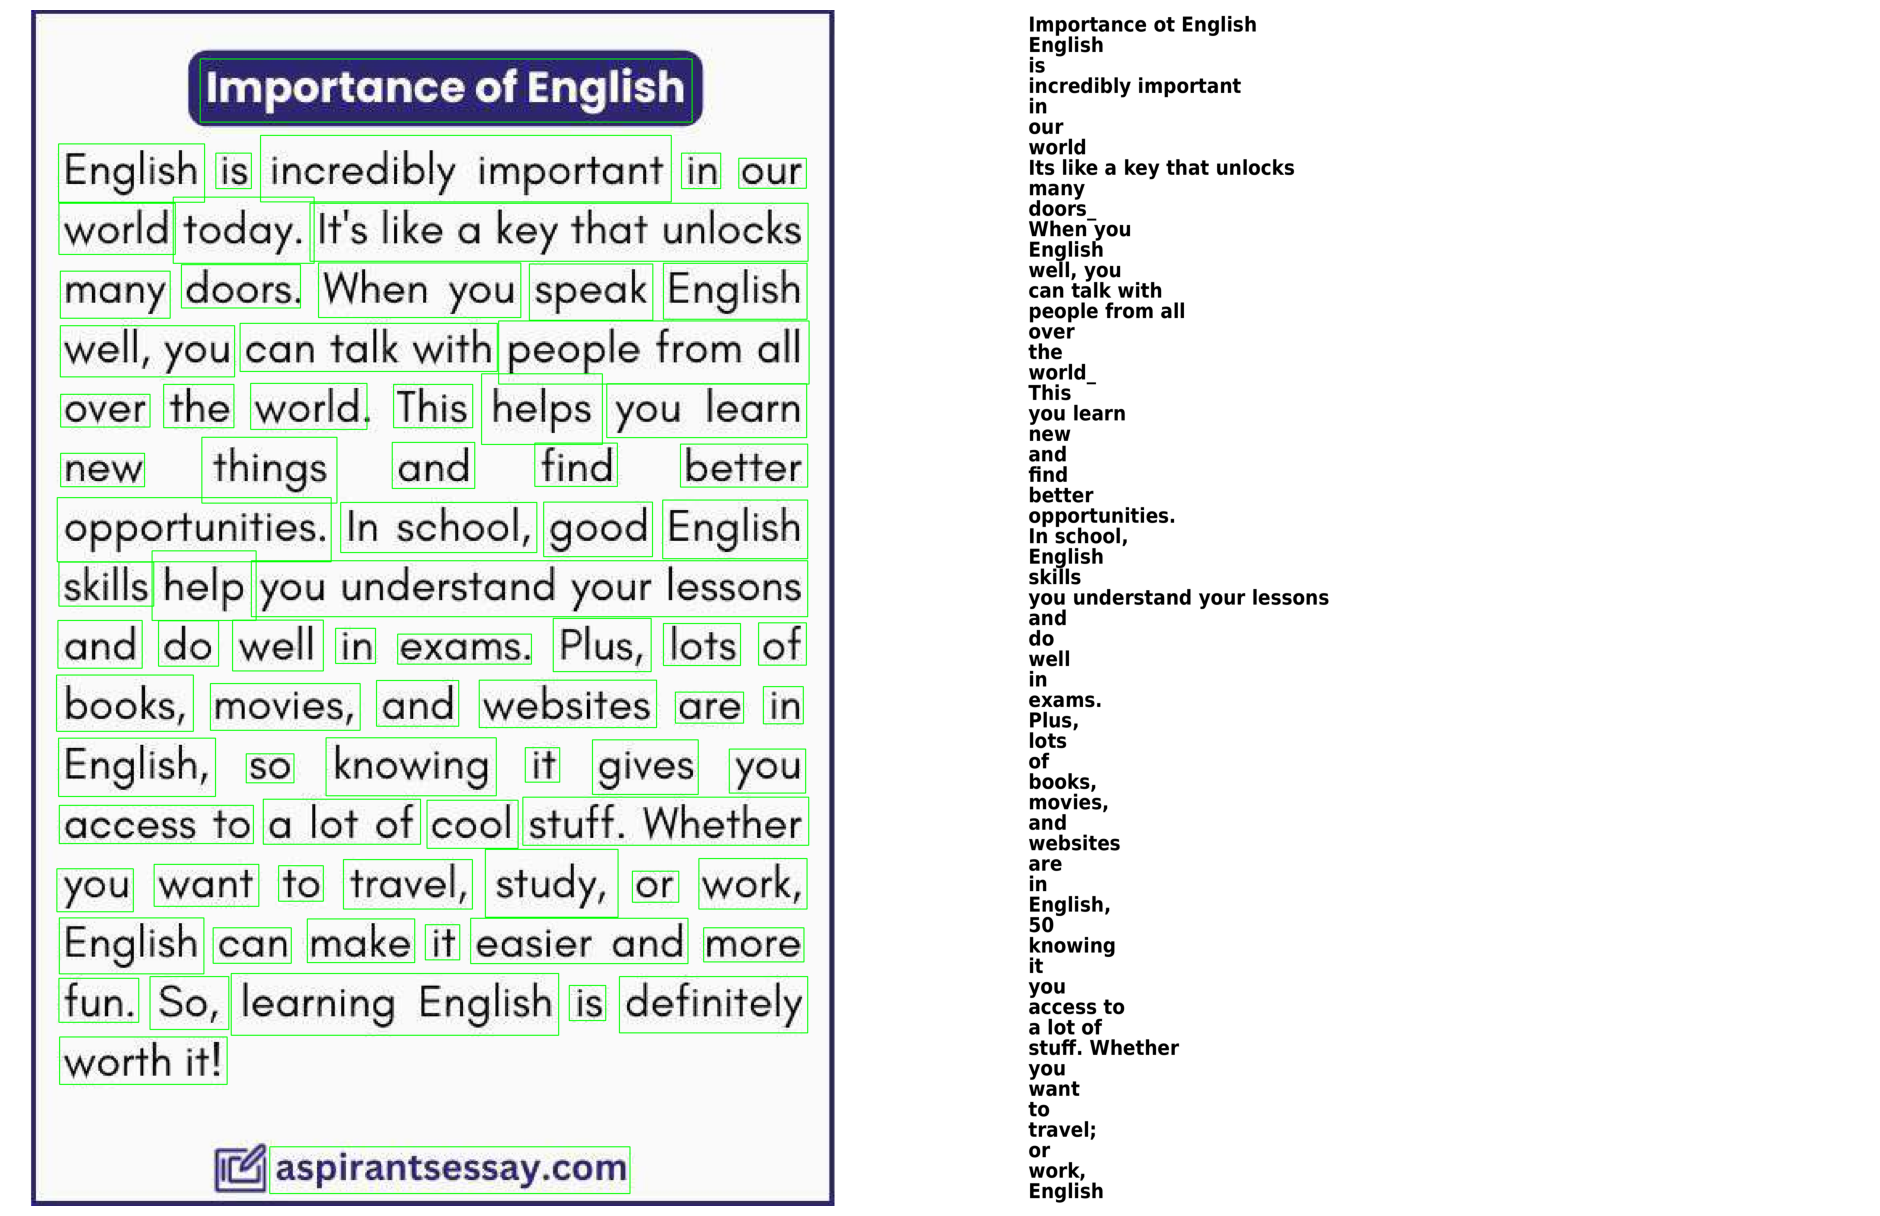

Processing EN PDF pages:  80%|████████  | 4/5 [00:20<00:04,  4.97s/it]

OCR results for page 4 saved to output_pdf_english/page_4.json
Text: Good Habits, Probability: 0.9998
Text: Good, Probability: 0.9999
Text: habits, Probability: 1.0000
Text: are, Probability: 1.0000
Text: essential for, Probability: 0.9988
Text: success, Probability: 0.9985
Text: Waking, Probability: 1.0000
Text: up early, Probability: 0.9963
Text: ensures, Probability: 1.0000
Text: a, Probability: 0.9933
Text: productive, Probability: 0.9999
Text: Planning ahead, Probability: 0.9961
Text: aids, Probability: 0.9971
Text: in, Probability: 0.9997
Text: managing, Probability: 1.0000
Text: time, Probability: 0.9989
Text: efficiently: Regular exercise keeps, Probability: 0.7901
Text: the, Probability: 0.9995
Text: healthy and, Probability: 0.9930
Text: the, Probability: 0.9999
Text: mind, Probability: 1.0000
Text: Reading daily enhances knowledge and, Probability: 0.9937
Text: vocabulary: Eating nutritious meals fuels, Probability: 0.9358
Text: energy, Probability: 1.0000
Text: levels:, Pro

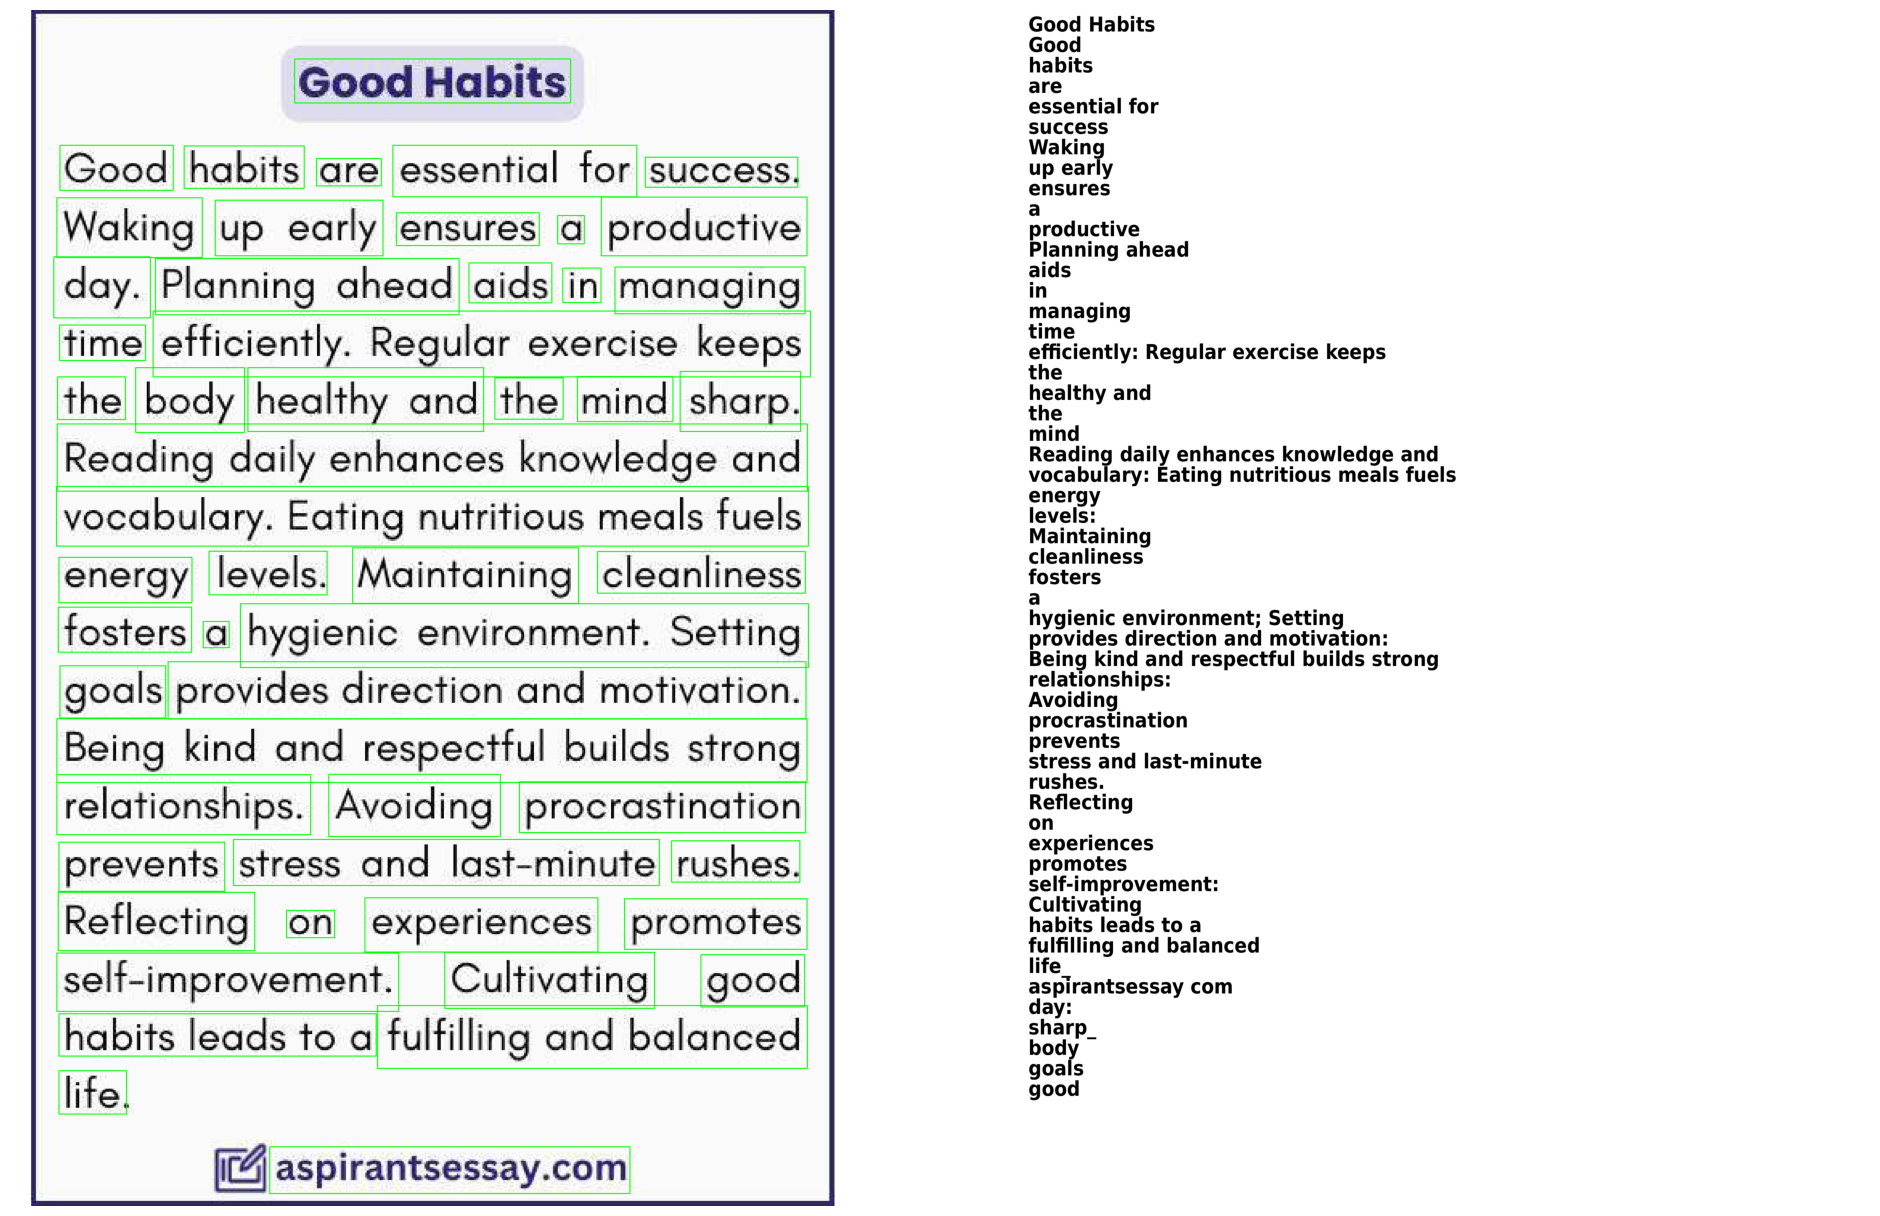

Processing EN PDF pages: 100%|██████████| 5/5 [00:25<00:00,  5.18s/it]

OCR results for page 5 saved to output_pdf_english/page_5.json
Extracted text saved to output_pdf_english/extracted_text.txt


Annotated PDF saved to output_pdf_english/annotated_output.pdf


Processing AR PDF pages:   0%|          | 0/3 [00:00<?, ?it/s]

Text: محمًد وعلى آل, Probability: 0.3263
Text: صل, Probability: 0.6232
Text: محمد, Probability: 0.4529
Text: آل, Probability: 0.9419
Text: إبراهيم و, Probability: 0.3073
Text: كمًا صلًيت, Probability: 0.2177
Text: إبر ا هيم, Probability: 0.3729
Text: إنًك حميد مجيد, Probability: 0.2454
Text: آل, Probability: 0.9729
Text: محمًد و, Probability: 0.2598
Text: محمًد, Probability: 0.3179
Text: كمًا بارت على إبراهيم وعلى آل, Probability: 0.4192
Text: إبر ا هيم, Probability: 0.4630
Text: إنك حميد مجيد, Probability: 0.3452
Text: ٤, Probability: 0.1424
Text: قق ص:, Probability: 0.0246
Text: 6ش , Probability: 0.0247
Text: اللهم, Probability: 0.3970
Text: على, Probability: 0.7449
Text: عًلى, Probability: 0.6057
Text: عًلى, Probability: 0.5873
Text: اللًهمً, Probability: 0.3735
Text: عًلى, Probability: 0.3009
Text: عًلى, Probability: 0.4088
Text: بارك, Probability: 0.9954


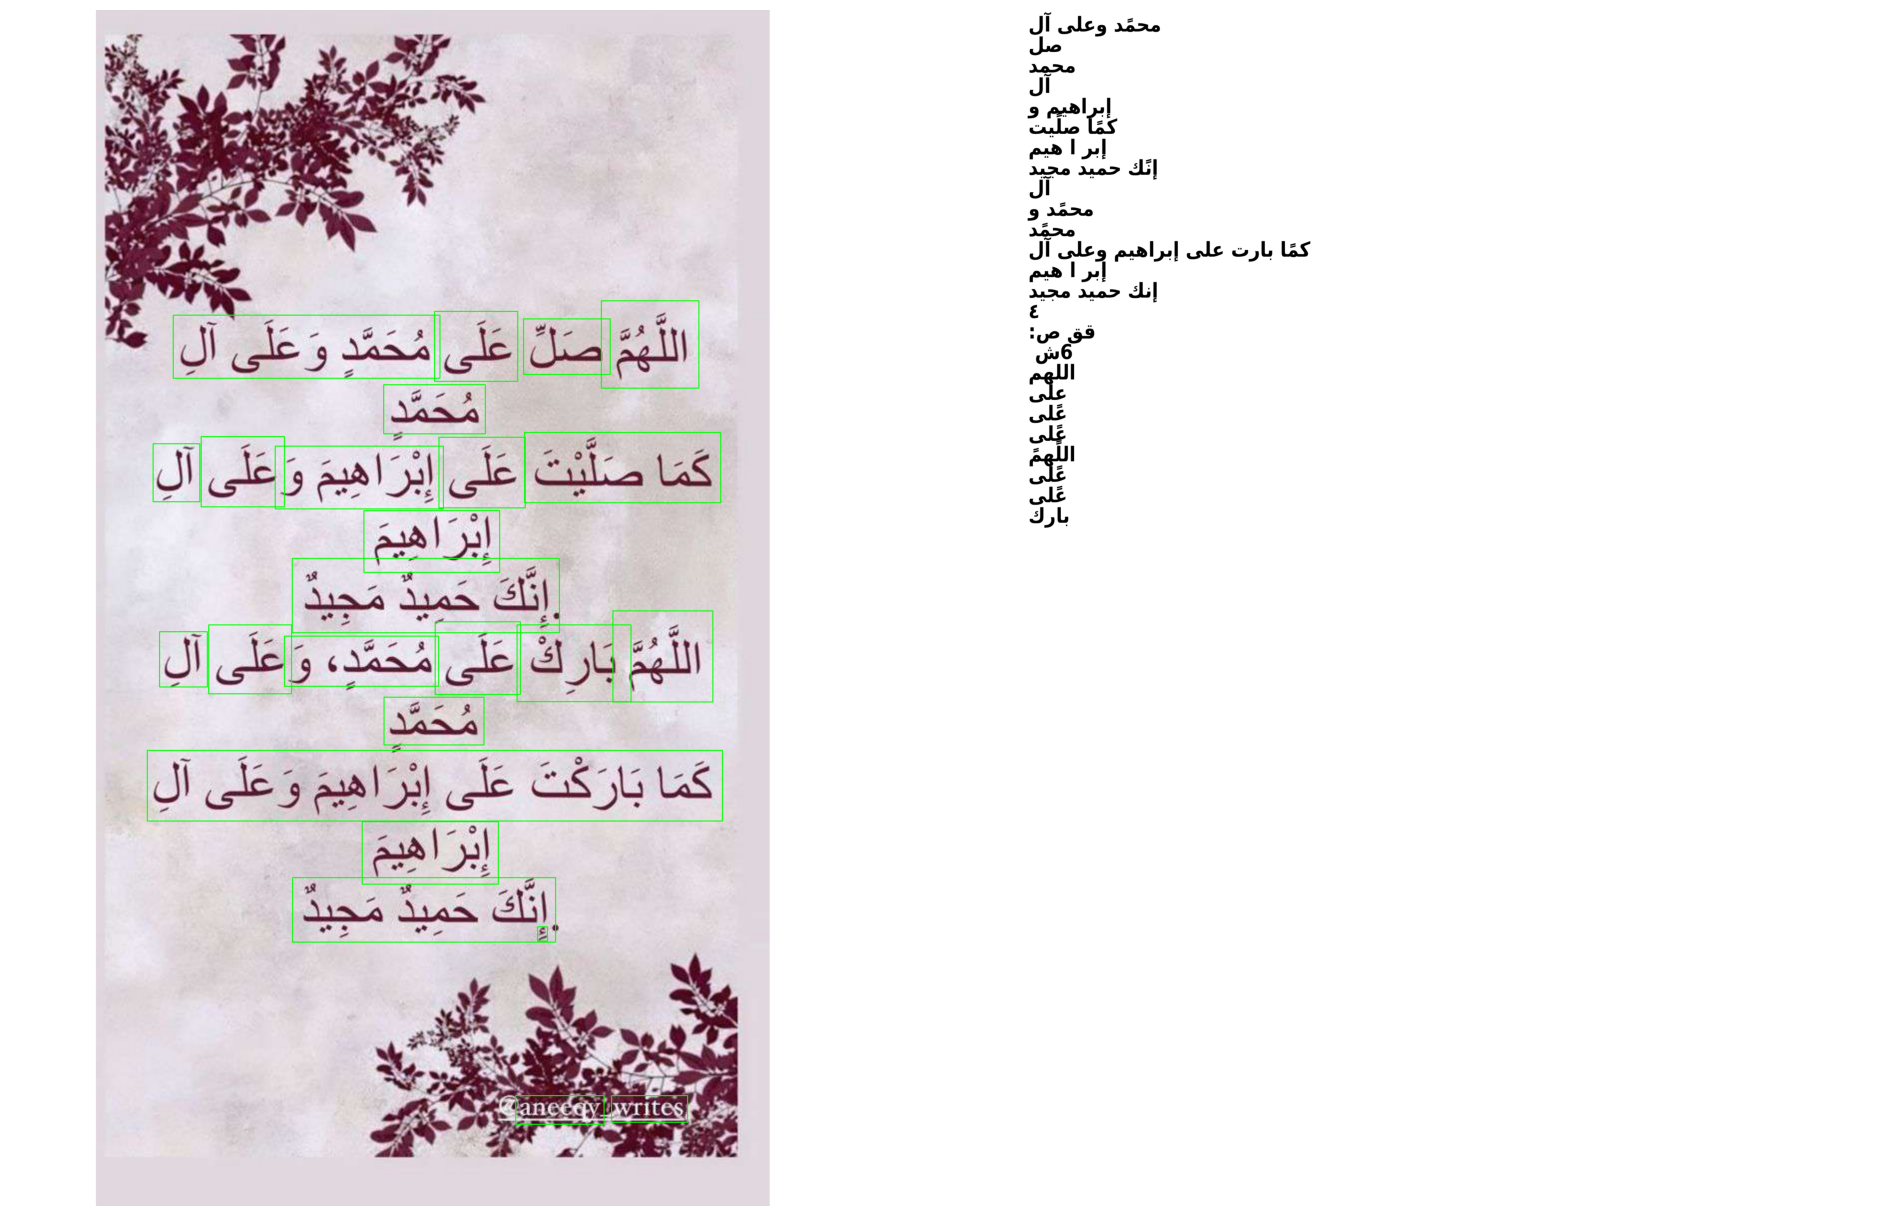

Processing AR PDF pages:  33%|███▎      | 1/3 [00:04<00:08,  4.31s/it]

OCR results for page 1 saved to output_pdf_arabic/page_1.json
Text: المحطًسة, Probability: 0.4782
Text: مقعد , Probability: 0.2351
Text: توجًهت إلى أول, Probability: 0.3532
Text: صعذت, Probability: 0.7156
Text: ووقفت, Probability: 0.9008
Text: آلرًف , Probability: 0.3911
Text: ووضعت, Probability: 0.9012
Text: ء, Probability: 0.1105
Text: أنظر إلى, Probability: 0.6145
Text: يتوجًهون, Probability: 0.3631
Text: مسر عون , Probability: 0.5613
Text: المسافرون, Probability: 0.5842
Text: بينمًا ترتفع, Probability: 0.2955
Text: وهم يحملون, Probability: 0.2480
Text: باعة آلصحف وآلمشروبات, Probability: 0.2084
Text: وبقيت, Probability: 0.6542
Text: دوًت, Probability: 0.4187
Text: أراقب, Probability: 0.2890
Text: آلنًافذة, Probability: 0.6374
Text: قرب, Probability: 0.7023
Text: واقفاً, Probability: 0.4947
Text: و, Probability: 0.0773
Text: فسي, Probability: 0.6926
Text: آلقطار ., Probability: 0.3542
Text: أمام, Probability: 0.8915
Text: على, Probability: 0.7478
Text: حقيبتي, Probability: 0.5031
Te

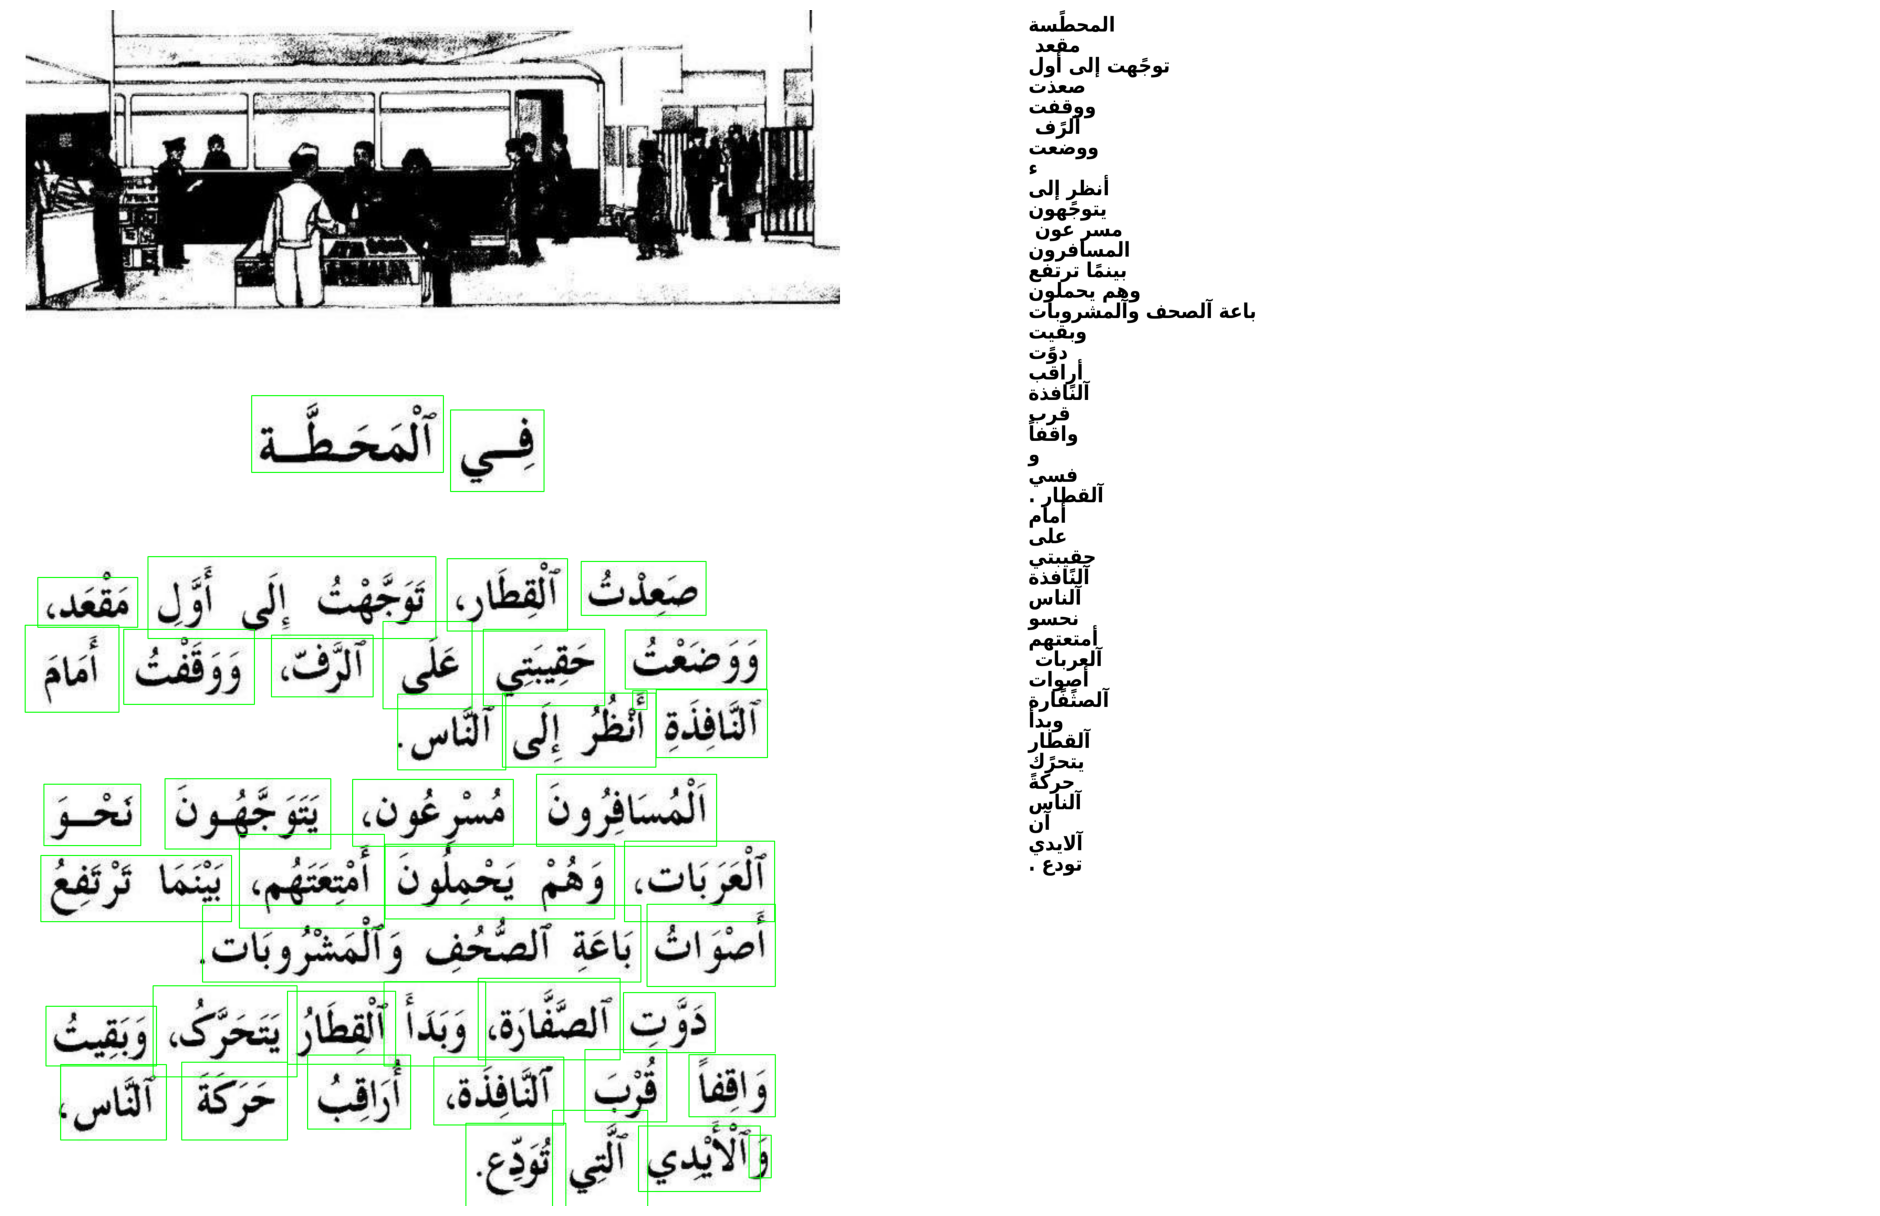

Processing AR PDF pages:  67%|██████▋   | 2/3 [00:08<00:04,  4.46s/it]

OCR results for page 2 saved to output_pdf_arabic/page_2.json
Text: إنًا الحيقاةً قصي دةً أبيت اتهًا, Probability: 0.1328
Text: أعممارتا والموت فيها القافية, Probability: 0.2422
Text: أين القصعور الشتًامخات وأهلهًا, Probability: 0.1517
Text: من باقية, Probability: 0.5997
Text: الجميع فهًل, Probability: 0.2485
Text: لوأنً خينًاً خًالد بيسن الورى, Probability: 0.2001
Text: مًا ماتً هارون وًمماتً معاوية, Probability: 0.1738
Text: اجتماحت الأيثام, Probability: 0.3432
Text: خاوية, Probability: 0.7745
Text: أعجتاز, Probability: 0.5040
Text: إيلبا أبو, Probability: 0.5667
Text: لهم, Probability: 0.7558
Text: بًاد, Probability: 0.5810
Text: أكرم, Probability: 0.8213
Text: أهلهًا, Probability: 0.7705
Text: فكتأنهم, Probability: 0.5623
Text: نخشل, Probability: 0.7012
Text: ماذي, Probability: 0.9697


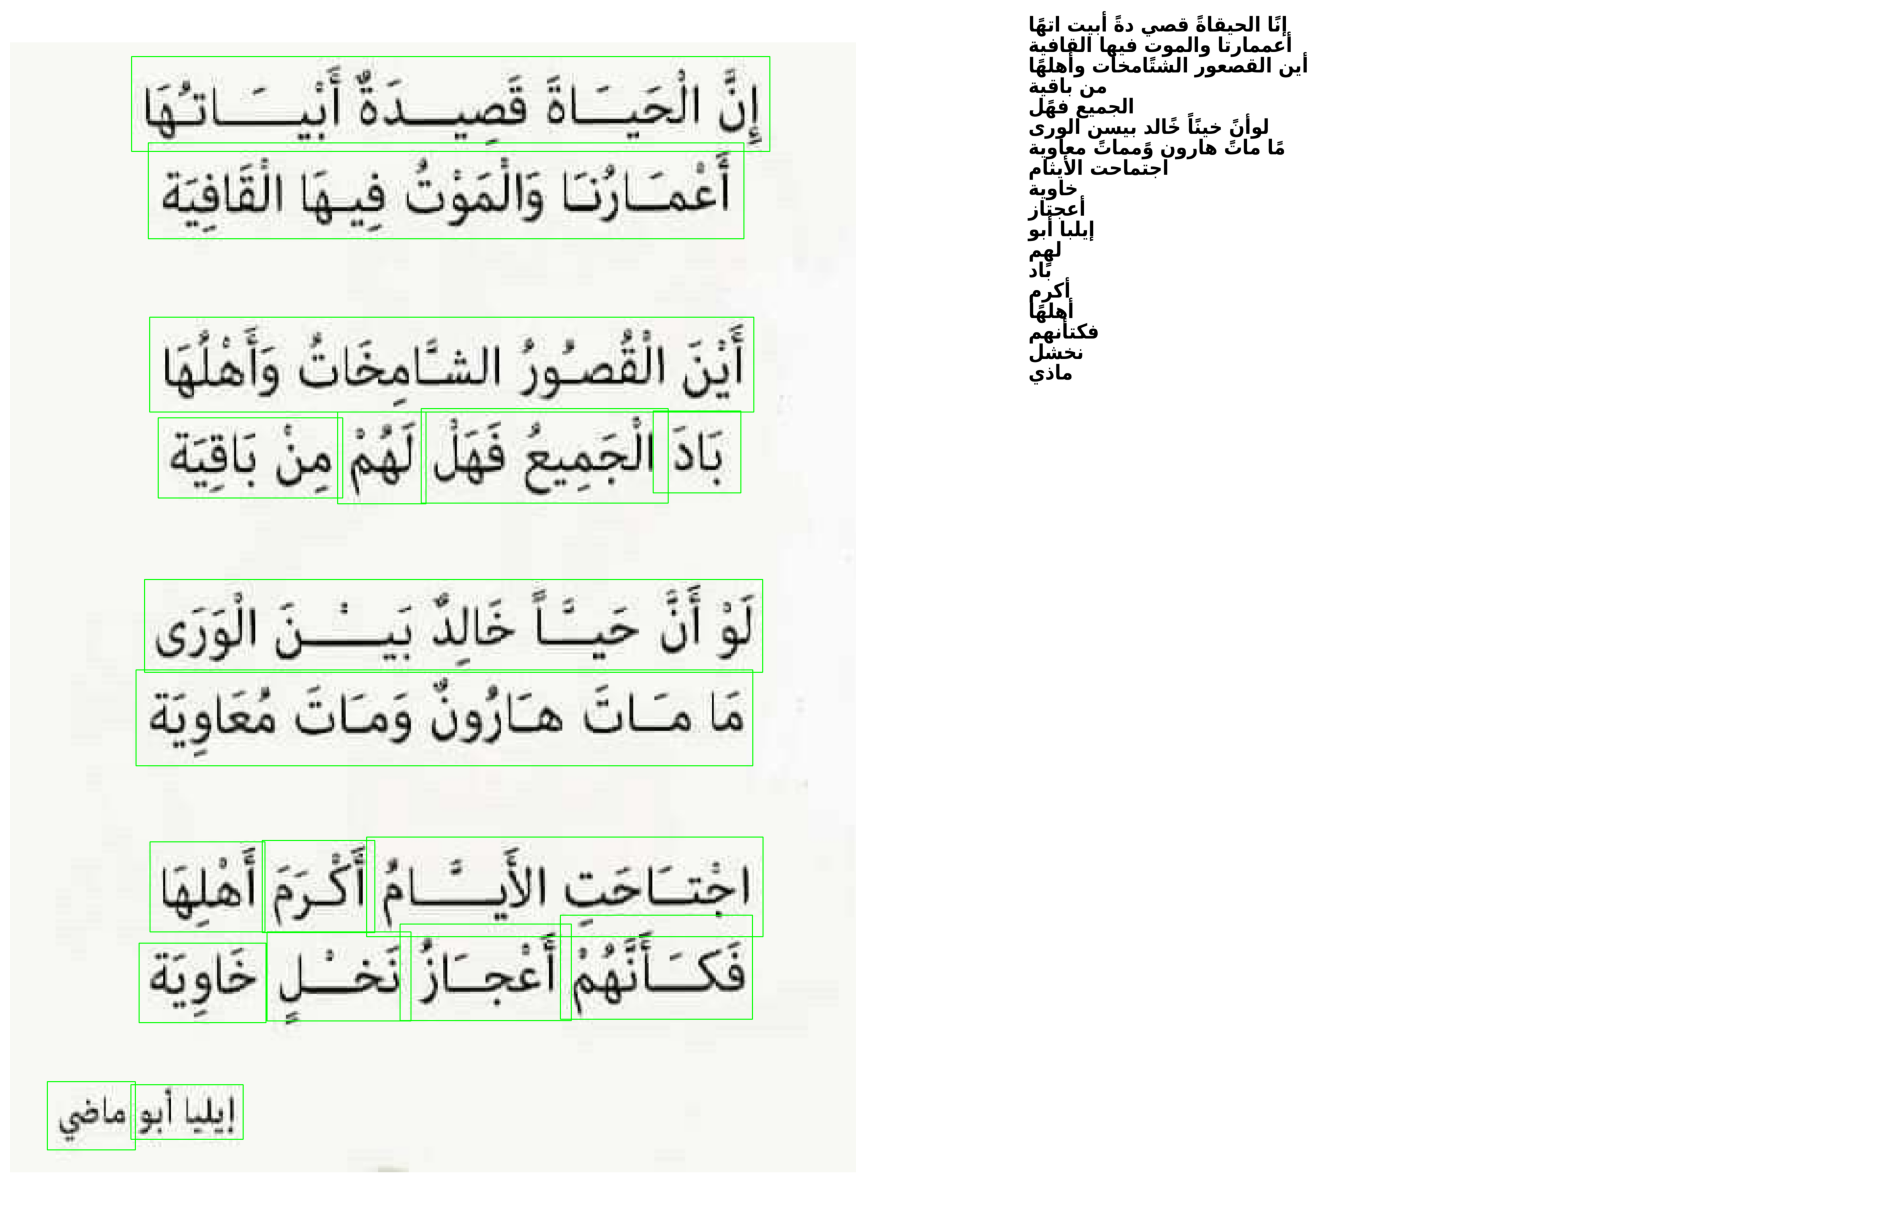

Processing AR PDF pages: 100%|██████████| 3/3 [00:13<00:00,  4.51s/it]

OCR results for page 3 saved to output_pdf_arabic/page_3.json
Extracted text saved to output_pdf_arabic/extracted_text.txt


Annotated PDF saved to output_pdf_arabic/annotated_output.pdf


In [7]:
# English PDF
english_pdf_path = '/content/Text Images_English.pdf'
ocr_pdf_to_individual_json(english_pdf_path, language='en', output_dir="output_pdf_english", save_pdf=True)

# Arabic PDF
arabic_pdf_path = '/content/Text Images _Arabic.pdf'
ocr_pdf_to_individual_json(arabic_pdf_path, language='ar', output_dir="output_pdf_arabic", save_pdf=True)



